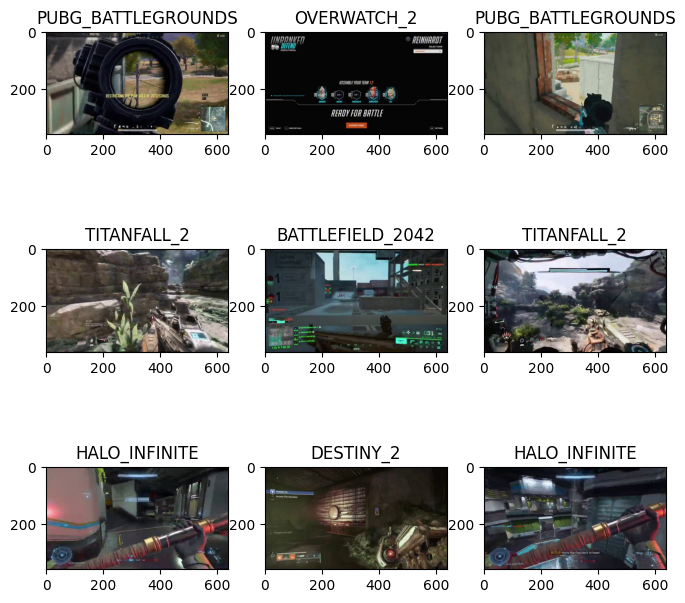

In [1]:
from datareader.dataset import GameScreenShotDataset
from matplotlib import pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision.datasets import ImageFolder

# autoreload
%load_ext autoreload
%autoreload 2

transform = transforms.Compose([
    transforms.Resize((360, 640)),
    transforms.ToTensor()
])

dataset_folder = './dataset/processed'

batch_size = 8
train_dataset = GameScreenShotDataset(root=os.path.join(dataset_folder, 'train'), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset = GameScreenShotDataset(root=os.path.join(dataset_folder, 'val'), transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)
test_dataset = GameScreenShotDataset(root=os.path.join(dataset_folder, 'test'), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label])
    plt.imshow(img.numpy().transpose(1,2,0))
plt.show()


In [2]:
# Try folder dataset
test_dataset = ImageFolder(root=os.path.join(dataset_folder, 'test'), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

# first data
data_iter = iter(test_dataloader)
images, labels = next(data_iter)
print(images.shape, labels.shape)
print(labels.dtype)

torch.Size([8, 3, 360, 640]) torch.Size([8])
torch.int64


In [33]:
from torchvision.models import resnet18, ResNet18_Weights, inception_v3, vit_b_16
from torch import nn
from tqdm import tqdm


# Training script
def train_model(model, dataloader, loss_fn, optimizer, epochs=10, limit=10000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    for i in range(0, epochs):
        model.train()
        
        running_loss = 0.0
        running_loss_total = 0.0
        epoch_loss = 0.0
        total = 0
        
        
        # Train
        # for i, batch in (pbar:=tqdm(enumerate(dataloader),unit="batch",total=len(dataloader))):
        for j, batch in enumerate(pbar:=tqdm(dataloader)):
            if total > limit:
                break
            
            X, y = batch
            X, y = X.float().to(device), y.float().to(device)
            # print(X.shape, y.shape)
            
            optimizer.zero_grad()
            
            # for inception model
            outputs, _ = model(X)
            _, preds = torch.max(outputs, 1)
            preds = preds.float()
            
            loss = loss_fn(preds,y)
            running_loss += loss.item() * X.size(0)
            epoch_loss += loss.item() * X.size(0)
            
            loss.requires_grad = True
            loss.backward()
            optimizer.step()
            
            total += y.size(0)
            running_loss_total += y.size(0)
            pbar.set_postfix(loss=running_loss/total)
            
            # print progress
            if j % 100 == 0:
                print(f"{i}/{len(dataloader)}, loss: {running_loss/running_loss_total}")
                running_loss = 0.0
                running_loss_total = 0.0
            
        print(f"Epoch {i+1}, loss: {epoch_loss/len(dataloader)}")
        epoch_loss = 0.0
        
        # Save model
        model_data = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": i
        }
        torch.save(model_data, f"model_epoch_{i}.pth")
        
        # Validate
        test_model(model, val_dataloader, loss_fn, optimizer,limit=100)
        
        
# Validate script
def test_model(model, dataloader, loss_fn, optimizer, limit = 100):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    
    correct = 0
    total = 0
    loss = 0

    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            if total > limit:
                break
            
            X, y = batch
            X, y = X.float().to(device), y.float().to(device)

            pred = model(X)
            
            _, predicted = torch.max(pred, 1)
            predicted = predicted.long()
            y = y.long()
            
            total += y.size(0)
            correct += (predicted == y).sum().item()
            loss += loss_fn(pred, y).item()
            
    print(f"Accuracy: {correct/total}")
    print(f"Average loss: {loss/total}")


In [31]:
# model = resnet18(pretrained=False)
# model.fc = nn.Linear(512, 30)
# print(model)

# inception
model = inception_v3(pretrained=False)
model.fc = nn.Linear(2048, 30)
# print(model)

c:\Users\kana_\.conda\envs\taiko-ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kana_\.conda\envs\taiko-ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\kana_\.conda\envs\taiko-ai\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [36]:
# model = resnet18(pretrained=False)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = loss_fn = nn.CrossEntropyLoss()

# train_model(model, train_dataloader, loss_func, optimizer, epochs=10, limit=100)
# test_model(model, val_dataloader, loss_func, optimizer, limit=18)


  0%|          | 1/11250 [00:01<6:10:18,  1.98s/it, loss=487]

0/11250, loss: 486.9972839355469


  0%|          | 13/11250 [00:23<5:34:31,  1.79s/it, loss=1.12e+3]


Epoch 1, loss: 1.335852189127604
Accuracy: 0.028846153846153848
Average loss: 0.42767702157680804


  0%|          | 1/11250 [00:03<9:46:21,  3.13s/it, loss=958]

1/11250, loss: 958.4007568359375


  0%|          | 13/11250 [00:23<5:44:35,  1.84s/it, loss=1.03e+3]


Epoch 2, loss: 1.2699498426649305
Accuracy: 0.019230769230769232
Average loss: 0.42640488881331223


  0%|          | 1/11250 [00:01<4:42:37,  1.51s/it, loss=1.1e+3]

2/11250, loss: 1100.157470703125


  0%|          | 13/11250 [00:17<4:17:25,  1.37s/it, loss=958]   


Epoch 3, loss: 1.204427072482639
Accuracy: 0.019230769230769232
Average loss: 0.4348792892235976


  0%|          | 1/11250 [00:01<4:01:54,  1.29s/it, loss=1.85e+3]

3/11250, loss: 1849.9967041015625


  0%|          | 13/11250 [00:17<4:10:36,  1.34s/it, loss=929]   

Epoch 4, loss: 1.2384091851128471


Accuracy: 0.028846153846153848
Average loss: 0.4271796185236711


  0%|          | 1/11250 [00:00<2:54:20,  1.08it/s, loss=2.28e+3]

4/11250, loss: 2282.015625


  0%|          | 13/11250 [00:17<4:17:00,  1.37s/it, loss=928]   


Epoch 5, loss: 1.2746650390625


KeyboardInterrupt: 

In [ ]:
# save model
data = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(data, 'model.pth')